# Deep Q-Network implementation.
## PyTorch debug mode

This homework shamelessly demands you to implement a DQN - an approximate q-learning algorithm with experience replay and target networks - and see if it works any better this way.

Original paper:
https://arxiv.org/pdf/1312.5602.pdf

**This notebook is given for debug.** The main DQN task will be in the same folder later. The tasks are similar and share most of the code. The main difference is in environments. In main notebook it can take some 2 hours for the agent to start improving so it seems reasonable to launch the algorithm on a simpler env first. Here it is CartPole and it will train in several minutes.

In [15]:
import os
import sys


if "google.colab" in sys.modules and not os.path.exists(".setup_complete"):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !wget -q https://raw.githubusercontent.com/girafe-ai/ml-mipt/develop_advanced_practice/homeworks_advanced/Lab2_RL/replay_buffer.py
    !wget -q https://raw.githubusercontent.com/girafe-ai/ml-mipt/develop_advanced_practice/homeworks_advanced/Lab2_RL/utils.py
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ["DISPLAY"] = ":1"

## CartPole again

In [16]:
import gym


def make_env(seed=None):
    # CartPole is wrapped with a time limit wrapper by default
    env = gym.make('CartPole-v1').unwrapped
    if seed is not None:
        env.seed(seed)
    return env

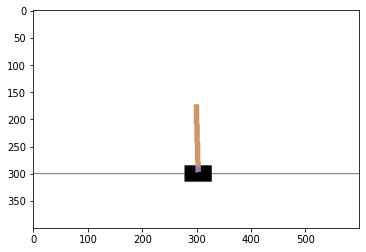

In [17]:
import matplotlib.pyplot as plt


env = make_env()
env.reset()
n_actions = env.action_space.n
state_shape = env.observation_space.shape
plt.imshow(env.render("rgb_array"))
plt.show()

## Building a network

We now need to build a neural network that can map observations to state q-values.
The model does not have to be huge yet. 1-2 hidden layers with < 200 neurons and ReLU activation will probably be enough. Batch normalization and dropout can spoil everything here.

In [220]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


class DQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=0):
        super().__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_dim = state_shape[0]

        # Define the network body
        hidden_dim = 128
        self.linear1 = nn.Linear(self.state_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim, n_actions)

    def forward(self, state_t):
        """
        takes agent's observation (tensor), returns qvalues (tensor)
        :param state_t: a batch states, shape = [batch_size, *state_dim=4]
        """
        # Use the network to compute qvalues for given state
        tmp = self.linear1(state_t)
        tmp = self.relu(tmp)
        qvalues = self.linear2(tmp)

        assert qvalues.requires_grad, "qvalues must be a torch tensor with grad"
        assert (
            len(qvalues.shape) == 2
            and qvalues.shape[0] == state_t.shape[0]
            and qvalues.shape[1] == n_actions
        )

        return qvalues

    def get_qvalues(self, states):
        """
        like forward, but works on numpy arrays, not tensors
        """
        model_device = next(self.parameters()).device
        states = torch.tensor(states, device=model_device, dtype=torch.float32)
        qvalues = self(states)
        return qvalues.detach().cpu().numpy()

    def sample_actions(self, qvalues):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy. """
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape

        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)

        should_explore = np.random.choice([0, 1], batch_size, p=[1 - epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [221]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
agent = DQNAgent(state_shape, n_actions, epsilon=0.5).to(device)

Now let's try out our agent to see if it raises any errors.

In [222]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            if greedy:
                action = qvalues.argmax(axis=-1)[0]
            else:
                action = agent.sample_actions(qvalues)[0]

            s, r, done, _ = env.step(action)
            reward += r
            if done:
                break

        rewards.append(reward)
    return np.mean(rewards)

In [223]:
evaluate(env, agent, n_games=1)

19.0

## Experience replay
For this assignment, we provide you with experience replay buffer. If you implemented experience replay buffer in previous bonus assigments, you can copy-paste it here in main notebook.

![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/exp_replay.png)

#### The interface is fairly simple:
* `exp_replay.add(obs, act, rw, next_obs, done)` - saves (s,a,r,s',done) tuple into the buffer
* `exp_replay.sample(batch_size)` - returns observations, actions, rewards, next_observations and is_done for `batch_size` random samples.
* `len(exp_replay)` - returns number of elements stored in replay buffer.

In [224]:
from replay_buffer import ReplayBuffer


exp_replay = ReplayBuffer(10)

for _ in range(30):
    exp_replay.add(env.reset(), env.action_space.sample(), 1.0, env.reset(), done=False)

obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(5)

assert (
    len(exp_replay) == 10
), "experience replay size should be 10 because that's what maximum capacity is"

In [225]:
def play_and_record(initial_state, agent, env, exp_replay, n_steps=1):
    """
    Play the game for exactly n steps, record every (s,a,r,s', done) to replay buffer.
    Whenever game ends, add record with done=True and reset the game.
    It is guaranteed that env has done=False when passed to this function.

    PLEASE DO NOT RESET ENV UNLESS IT IS "DONE"

    :returns: return sum of rewards over time and the state in which the env stays
    """
    s = initial_state
    sum_rewards = 0

    # Play the game for n_steps as per instructions above

#---------------------------------
    for step in range(n_steps):
        qvalues = agent.get_qvalues([s])
        action = agent.sample_actions(qvalues)[0]
        s_new, r, done, _ = env.step(action)
        exp_replay.add(s, action, r, s_new, done)
        sum_rewards += r

        s = s_new
        
        if done:
            done = False
            s = env.reset()


    return sum_rewards, s

In [226]:
# testing
exp_replay = ReplayBuffer(2000)

state = env.reset()
play_and_record(state, agent, env, exp_replay, n_steps=1000)

assert (
    len(exp_replay) == 1000
), "play_and_record should have added exactly 1000 steps, " "but instead added %i" % len(exp_replay)
is_dones = list(zip(*exp_replay._storage))[-1]

assert 0 < np.mean(is_dones) < 0.1, (
    f"Please make sure you restart the game whenever it is 'done' and record the is_done correctly into the buffer."
    f"Got {np.mean(is_dones)} is_done rate over {len(exp_replay)} steps. [If you think it's your tough luck, just re-run the test]"
)

for _ in range(100):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(10)
    assert obs_batch.shape == next_obs_batch.shape == (10,) + state_shape
    assert act_batch.shape == (
        10,
    ), "actions batch should have shape (10,) but is instead %s" % str(act_batch.shape)
    assert reward_batch.shape == (
        10,
    ), "rewards batch should have shape (10,) but is instead %s" % str(reward_batch.shape)
    assert is_done_batch.shape == (
        10,
    ), "is_done batch should have shape (10,) but is instead %s" % str(is_done_batch.shape)
    assert [int(i) in (0, 1) for i in is_dones], "is_done should be strictly True or False"
    assert [0 <= a < n_actions for a in act_batch], "actions should be within [0, n_actions]"

print("Well done!")

Well done!


## Target networks

We also employ the so called "target network" - a copy of neural network weights to be used for reference Q-values:

The network itself is an exact copy of agent network, but it's parameters are not trained. Instead, they are moved here from agent's actual network every so often.

$$ Q_{reference}(s,a) = r + \gamma \cdot \max _{a'} Q_{target}(s',a') $$

![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/target_net.png)

In [227]:
target_network = DQNAgent(state_shape, n_actions, epsilon=0.5).to(device)
# This is how you can load weights from agent into target network
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

## Learning with... Q-learning
Here we write a function similar to `agent.update` from tabular q-learning.

Compute Q-learning TD error:

$$ L = { 1 \over N} \sum_i [ Q_{\theta}(s,a) - Q_{reference}(s,a) ] ^2 $$

With Q-reference defined as

$$ Q_{reference}(s,a) = r(s,a) + \gamma \cdot max_{a'} Q_{target}(s', a') $$

Where
* $Q_{target}(s',a')$ denotes q-value of next state and next action predicted by __target_network__
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.


__Note 1:__ there's an example input below. Feel free to experiment with it before you write the function.

__Note 2:__ compute_td_loss is a source of 99% of bugs in this homework. If reward doesn't improve, it often helps to go through it line by line [with a rubber duck](https://rubberduckdebugging.com/).

In [228]:
def compute_td_loss(
    states,
    actions,
    rewards,
    next_states,
    done,
    agent,
    target_network,
    gamma=0.99,
    check_shapes=False,
):
    """Compute td loss using torch operations only. Use the formula above."""
    states = torch.tensor(
        states, device=device, dtype=torch.float32
    )  # shape: [batch_size, state_size]
    actions = torch.tensor(actions, device=device, dtype=torch.long)  # shape: [batch_size]
    rewards = torch.tensor(rewards, device=device, dtype=torch.float32)  # shape: [batch_size]
    next_states = torch.tensor(
        next_states, device=device, dtype=torch.float32
    )  # shape: [batch_size, state_size]
    done = torch.tensor(done, device=device, dtype=torch.bool)  # shape: [batch_size]

    # get q-values for all actions in current states
    predicted_qvalues = agent(states)

    # select q-values for chosen actions
    predicted_qvalues_for_actions = predicted_qvalues[range(states.shape[0]), actions]

    # compute q-values for all actions in next states
    predicted_next_qvalues = target_network(next_states)

    # compute V*(next_states) using predicted next q-values
    next_state_values = predicted_next_qvalues.max(dim=1).values

    assert next_state_values.dtype == torch.float32

    # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
    # at the last state we shall use simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
    target_qvalues_for_actions = rewards + gamma * next_state_values
    target_qvalues_for_actions = torch.where(done, rewards, target_qvalues_for_actions)

    # mean squared error loss to minimize
    loss = F.mse_loss(predicted_qvalues_for_actions, target_qvalues_for_actions.detach())

    if check_shapes:
        assert (
            predicted_next_qvalues.data.dim() == 2
        ), "make sure you predicted q-values for all actions in next state"
        assert (
            next_state_values.data.dim() == 1
        ), "make sure you computed V(s') as maximum over just the actions axis and not all axes"
        assert (
            target_qvalues_for_actions.data.dim() == 1
        ), "there's something wrong with target q-values, they must be a vector"

    return loss

Sanity checks

In [229]:
obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(10)

loss = compute_td_loss(
    obs_batch,
    act_batch,
    reward_batch,
    next_obs_batch,
    is_done_batch,
    agent,
    target_network,
    gamma=0.99,
    check_shapes=True,
)
loss.backward()

assert (
    loss.requires_grad and tuple(loss.data.size()) == ()
), "you must return scalar loss - mean over batch"
assert np.any(
    next(agent.parameters()).grad.data.cpu().numpy() != 0
), "loss must be differentiable w.r.t. network weights"
assert np.all(
    next(target_network.parameters()).grad is None
), "target network should not have grads"

## Main loop

It's time to put everything together and see if it learns anything.

In [230]:
# Choose your favourite seed.
seed = 0

env = make_env(seed)
state = env.reset()

agent = DQNAgent(state_shape, n_actions, epsilon=1).to(device)
target_network = DQNAgent(state_shape, n_actions, epsilon=1).to(device)
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

In [231]:
import utils


exp_replay = ReplayBuffer(10_000)
for i in range(100):
    if not utils.is_enough_ram(min_available_gb=0.1):
        print(
            """
            Less than 100 Mb RAM available. 
            Make sure the buffer size in not too huge.
            Also check, maybe other processes consume RAM heavily.
            """
        )
        break

    play_and_record(state, agent, env, exp_replay, n_steps=100)

print(len(exp_replay))

10000


Don't hesitate to play with the hyperparameters in the following cell.

In [232]:
timesteps_per_epoch = 1
batch_size = 32
total_steps = 50_000
decay_steps = 30_000

opt = torch.optim.Adam(agent.parameters(), lr=1e-4)

init_epsilon = 1
final_epsilon = 0.1

loss_freq = 20
refresh_target_network_freq = 100
eval_freq = 1000

max_grad_norm = 50

In [233]:
mean_rw_history = []
td_loss_history = []
grad_norm_history = []
initial_state_v_history = []

buffer size = 10000, epsilon = 0.10000


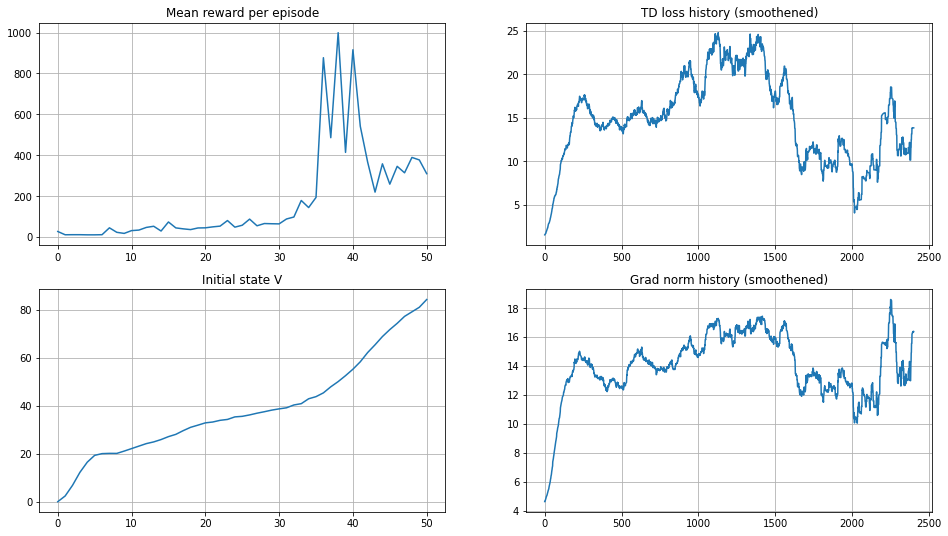

In [234]:
from IPython.display import clear_output


state = env.reset()
for step in range(total_steps + 1):
    if not utils.is_enough_ram(min_available_gb=0.1):
        print('less that 100 Mb RAM available, freezing')
        print('make sure everything is ok and make KeyboardInterrupt to continue')
        try:
            while True:
                pass
        except KeyboardInterrupt:
            pass

    agent.epsilon = utils.linear_decay(init_epsilon, final_epsilon, step, decay_steps)

    # play
    _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)

    # train

    # Sample batch_size of data from experience replay and compute td loss.
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(batch_size)
    loss = compute_td_loss(obs_batch,
        act_batch,
        reward_batch,
        next_obs_batch,
        is_done_batch,
        agent,
        target_network,
        gamma=0.99,
        check_shapes=False,
    )

    opt.zero_grad()
    loss.backward()
    grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
    opt.step()

    if step % loss_freq == 0:
        td_loss_history.append(loss.data.cpu().item())
        grad_norm_history.append(grad_norm)

    if step % refresh_target_network_freq == 0:
        # Load agent weights into target_network
        target_network.load_state_dict(agent.state_dict())

    if step % eval_freq == 0:
        # eval the agent
        mean_rw_history.append(
            evaluate(make_env(seed=step), agent, n_games=3, greedy=True, t_max=1000)
        )
        initial_state_q_values = agent.get_qvalues([make_env(seed=step).reset()])
        initial_state_v_history.append(np.max(initial_state_q_values))

        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" % (len(exp_replay), agent.epsilon))

        plt.figure(figsize=[16, 9])
        plt.subplot(2, 2, 1)
        plt.title("Mean reward per episode")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(td_loss_history[-1])
        plt.subplot(2, 2, 2)
        plt.title("TD loss history (smoothened)")
        plt.plot(utils.smoothen(td_loss_history))
        plt.grid()

        plt.subplot(2, 2, 3)
        plt.title("Initial state V")
        plt.plot(initial_state_v_history)
        plt.grid()

        plt.subplot(2, 2, 4)
        plt.title("Grad norm history (smoothened)")
        plt.plot(utils.smoothen(grad_norm_history))
        plt.grid()

        plt.show()

In [235]:
final_score = evaluate(make_env(), agent, n_games=30, greedy=True, t_max=1000)
print('final score:', final_score)
assert final_score > 300, 'not good enough for DQN'
print('Well done')

final score: 327.76666666666665
Well done


It works!